# Analysis of the DSAIR model

> A number of replications and extensions of the models provided in Han et al. ([2020](https://doi.org/10.1613/jair.1.12225) , [2021](https://doi.org/10.1371/journal.pone.0244592), [2022](https://doi.org/10.1016/j.techsoc.2021.101843) )

In [ ]:
#| default_exp analysis_dsair

In [ ]:
#| hide
#| export
from gh_pages_example.conditions import *
from gh_pages_example.methods import *
from gh_pages_example.payoffs import *
from gh_pages_example.plot_utils import *
from gh_pages_example.types import *
from gh_pages_example.utils import *

import typing
import warnings

import fastcore.test
import matplotlib as mpl
import matplotlib.pyplot as plt
from nbdev.showdoc import *
import nptyping
import numpy as np
import pandas
import seaborn as sns

This notebook contains a number of analyses of different versions of the DSAIR model.

Each analysis involves a number of steps:

1. Create parameter space
2. Run the model
3. Process the results
4. Visualise results and explain what we observe

## Baseline DSAIR model

### Create parameter space

In [ ]:
#| export
valid_dtypes = typing.Union[float, list[float], np.ndarray, dict]
def build_DSAIR(b:valid_dtypes=4, # benefit: The size of the per round benefit of leading the AI development race, b>0
                c:valid_dtypes=1, # cost: The cost of implementing safety recommendations per round, c>0
                s:valid_dtypes={"start":1, # speed: The speed advantage from choosing to ignore safety recommendations, s>1
                                "stop":5.1,
                                "step":0.1}, 
                p:valid_dtypes={"start":0, # avoid_risk: The probability that unsafe firms avoid an AI disaster, p ∈ [0, 1]
                                "stop":1.02,
                                "step":0.02}, 
                B:valid_dtypes=10**4, # prize: The size of the prize from winning the AI development race, B>>b
                W:valid_dtypes=100, # timeline: The anticipated timeline until the development race has a winner if everyone behaves safely, W ∈ [10, 10**6]
                pfo:valid_dtypes=0, # detection risk: The probability that firms who ignore safety precautions are found out, pfo ∈ [0, 1]
                α:valid_dtypes=0, # the cost of rewarding/punishing a peer
                γ:valid_dtypes=0, # the effect of a reward/punishment on a developer's speed
                ϵ:valid_dtypes=0, # commitment_cost: The cost of setting up and maintaining a voluntary commitment, ϵ > 0
                ω:valid_dtypes=0, # noise: Noise in arranging an agreement, with some probability they fail to succeed in making an agreement, ω ∈ [0, 1]
                collective_risk:valid_dtypes=0, # The likelihood that a disaster affects all actors
                β:valid_dtypes=0.01, # learning_rate: the rate at which players imitate each other
                Z:int=100, # population_size: the number of players in the evolutionary game
                strategy_set:list[str]=["AS", "AU"], # the set of available strategies
                exclude_args:list[str]=['Z', 'strategy_set'], # a list of arguments that should be returned as they are
                override:bool=False, # whether to build the grid if it is very large
                drop_args:list[str]=['override', 'exclude_args', 'drop_args'], # a list of arguments to drop from the final result
               ) -> dict: # A dictionary containing items from `ModelTypeDSAIR` and `ModelTypeEGT`
    """Initialise baseline DSAIR models for all combinations of the provided
    parameter valules. By default, we create models for replicating Figure 1
    of Han et al. 2021."""
    
    saved_args = locals()
    models = model_builder(saved_args,
                           exclude_args=exclude_args,
                           override=override,
                           drop_args=drop_args)
    return models

In [ ]:
show_doc(build_DSAIR)

---

[source](https://github.com/PaoloBova/gh-pages-example/blob/main/gh_pages_example/analysis_dsair.py#L28){target="_blank" style="float:right; font-size:smaller"}

### build_DSAIR

>      build_DSAIR (b:Union[float,list[float],numpy.ndarray,dict]=4,
>                   c:Union[float,list[float],numpy.ndarray,dict]=1,
>                   s:Union[float,list[float],numpy.ndarray,dict]={'start': 1,
>                   'stop': 5.1, 'step': 0.1},
>                   p:Union[float,list[float],numpy.ndarray,dict]={'start': 0,
>                   'stop': 1.02, 'step': 0.02},
>                   B:Union[float,list[float],numpy.ndarray,dict]=10000,
>                   W:Union[float,list[float],numpy.ndarray,dict]=100,
>                   pfo:Union[float,list[float],numpy.ndarray,dict]=0,
>                   α:Union[float,list[float],numpy.ndarray,dict]=0,
>                   γ:Union[float,list[float],numpy.ndarray,dict]=0,
>                   ε:Union[float,list[float],numpy.ndarray,dict]=0,
>                   ω:Union[float,list[float],numpy.ndarray,dict]=0, collective_
>                   risk:Union[float,list[float],numpy.ndarray,dict]=0,
>                   β:Union[float,list[float],numpy.ndarray,dict]=0.01,
>                   Z:int=100, strategy_set:list[str]=['AS', 'AU'],
>                   exclude_args:list[str]=['Z', 'strategy_set'],
>                   override:bool=False, drop_args:list[str]=['override',
>                   'exclude_args', 'drop_args'])

Initialise baseline DSAIR models for all combinations of the provided
parameter valules. By default, we create models for replicating Figure 1
of Han et al. 2021.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| b | Union | 4 | benefit: The size of the per round benefit of leading the AI development race, b>0 |
| c | Union | 1 | cost: The cost of implementing safety recommendations per round, c>0 |
| s | Union | {'start': 1, 'stop': 5.1, 'step': 0.1} | speed: The speed advantage from choosing to ignore safety recommendations, s>1 |
| p | Union | {'start': 0, 'stop': 1.02, 'step': 0.02} | avoid_risk: The probability that unsafe firms avoid an AI disaster, p ∈ [0, 1] |
| B | Union | 10000 | prize: The size of the prize from winning the AI development race, B>>b |
| W | Union | 100 | timeline: The anticipated timeline until the development race has a winner if everyone behaves safely, W ∈ [10, 10**6] |
| pfo | Union | 0 | detection risk: The probability that firms who ignore safety precautions are found out, pfo ∈ [0, 1] |
| α | Union | 0 | the cost of rewarding/punishing a peer |
| γ | Union | 0 | the effect of a reward/punishment on a developer's speed |
| ε | Union | 0 | commitment_cost: The cost of setting up and maintaining a voluntary commitment, ϵ > 0 |
| ω | Union | 0 | noise: Noise in arranging an agreement, with some probability they fail to succeed in making an agreement, ω ∈ [0, 1] |
| collective_risk | Union | 0 | The likelihood that a disaster affects all actors |
| β | Union | 0.01 | learning_rate: the rate at which players imitate each other |
| Z | int | 100 | population_size: the number of players in the evolutionary game |
| strategy_set | list | ['AS', 'AU'] | the set of available strategies |
| exclude_args | list | ['Z', 'strategy_set'] | a list of arguments that should be returned as they are |
| override | bool | False | whether to build the grid if it is very large |
| drop_args | list | ['override', 'exclude_args', 'drop_args'] | a list of arguments to drop from the final result |
| **Returns** | **dict** |  | **A dictionary containing items from `ModelTypeDSAIR` and `ModelTypeEGT`** |

In [ ]:
#| exec_doc
#| echo:true
models = build_DSAIR()

In [ ]:
#| hide
models

{'s': array([1., 1., 1., ..., 5., 5., 5.]),
 'p': array([0.  , 0.02, 0.04, ..., 0.96, 0.98, 1.  ]),
 'b': array([4, 4, 4, ..., 4, 4, 4]),
 'c': array([1, 1, 1, ..., 1, 1, 1]),
 'B': array([10000, 10000, 10000, ..., 10000, 10000, 10000]),
 'W': array([100, 100, 100, ..., 100, 100, 100]),
 'pfo': array([0, 0, 0, ..., 0, 0, 0]),
 'α': array([0, 0, 0, ..., 0, 0, 0]),
 'γ': array([0, 0, 0, ..., 0, 0, 0]),
 'ε': array([0, 0, 0, ..., 0, 0, 0]),
 'ω': array([0, 0, 0, ..., 0, 0, 0]),
 'collective_risk': array([0, 0, 0, ..., 0, 0, 0]),
 'β': array([0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01]),
 'Z': 100,
 'strategy_set': ['AS', 'AU']}

In [ ]:
#| hide
{k:v.shape for k,v in models.items() if isinstance(v, np.ndarray)}

{'s': (2091,),
 'p': (2091,),
 'b': (2091,),
 'c': (2091,),
 'B': (2091,),
 'W': (2091,),
 'pfo': (2091,),
 'α': (2091,),
 'γ': (2091,),
 'ε': (2091,),
 'ω': (2091,),
 'collective_risk': (2091,),
 'β': (2091,)}

### Run the model

I use `thread_macro` to pipe the `models` I created earlier through each function that follows.

I first build the payoff matrices for each model, and compute some analytical thresholds that will be useful in our discussion. Finally, I pass the result to `markov_chain`, a method for computing the distribution of strategies that will be present in the population in the long run.

In [ ]:
#| exec_doc
#| echo:true
results = thread_macro(models,
                       payoffs_sr,
                       payoffs_lr,
                       threshold_society_prefers_safety_dsair,
                       threshold_risk_dominant_safety_dsair,
                       markov_chain,
                      )

In [ ]:
#| hide
{k:v.shape for k,v in results.items() if isinstance(v, np.ndarray)}

{'s': (2091,),
 'p': (2091,),
 'b': (2091,),
 'c': (2091,),
 'B': (2091,),
 'W': (2091,),
 'pfo': (2091,),
 'α': (2091,),
 'γ': (2091,),
 'ε': (2091,),
 'ω': (2091,),
 'collective_risk': (2091,),
 'β': (2091,),
 'payoffs_sr': (2091, 2, 2),
 'payoffs': (2091, 2, 2),
 'threshold_society_prefers_safety': (2091,),
 'threshold_risk_dominant_safety': (2091,),
 'transition_matrix': (2091, 2, 2),
 'ergodic': (2091, 2)}

### Process the results

Now that we have collected some results, we need to process them so that we can display what we want to.

The general approach I follow is to flatten the `results` dictionary and convert it into a [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html) dataframe.

Here, we also compute the risk of an AI related disaster, $p_{risk} = 1 - p$

Here are a few convenience functions I've made for handling the data

In [ ]:
#| export
dropped_items_warning=f"""Several items in `results` are not suitable for conversion to
a dataframe. This may be because they are not numpy arrays or because they
are not the same size as the other items. 

The following items were dropped: """
def results_to_dataframe_egt(results:dict, # A dictionary containing items from `ModelTypeEGT`.
                             suppress:bool=True, # Supress the dropped items warning
                            ):
    """Convert results to a dataframe, keeping only items which are valid for
    a dataframe to have."""
    flat_results = {k:v
                    for k,v in results.items()
                    if (isinstance(v, np.ndarray)
                        and not v.ndim > 1)}
    for i, strategy in enumerate(results['strategy_set']):
        flat_results[strategy + "_frequency"] = results['ergodic'][:,i]
    dropped_items = [k for k in results.keys() if k not in flat_results]
    if (len(dropped_items)>0 and not suppress):
        print(f"{dropped_items_warning} {dropped_items}")
    return pandas.DataFrame(flat_results)    

In [ ]:
#| export
def process_dsair_data(data):
    """Process DSAIR model results dataframe."""
    data['pr'] = np.round(1 - data['p'].values, 2)
    data['s'] = np.round(data['s'].values, 2)
    return data

In [ ]:
#| exec_doc
df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)

In [ ]:
#| echo:false
df

,s,p,b,c,B,W,pfo,α,γ,ε,ω,collective_risk,β,threshold_society_prefers_safety,threshold_risk_dominant_safety,AS_frequency,AU_frequency,pr
0,1.0,0.00,4,1,10000,100,0,0,0,0,0,0,0.01,0.019231,0.662338,1.000000e+00,8.508121e-12,1.00
1,1.0,0.02,4,1,10000,100,0,0,0,0,0,0,0.01,0.019231,0.662338,1.000000e+00,3.927629e-11,0.98
2,1.0,0.04,4,1,10000,100,0,0,0,0,0,0,0.01,0.019231,0.662338,1.000000e+00,1.813123e-10,0.96
3,1.0,0.06,4,1,10000,100,0,0,0,0,0,0,0.01,0.019231,0.662338,1.000000e+00,8.369975e-10,0.94
4,1.0,0.08,4,1,10000,100,0,0,0,0,0,0,0.01,0.019231,0.662338,1.000000e+00,3.863857e-09,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086,5.0,0.92,4,1,10000,100,0,0,0,0,0,0,0.01,0.797619,0.932921,0.000000e+00,1.000000e+00,0.08
2087,5.0,0.94,4,1,10000,100,0,0,0,0,0,0,0.01,0.797619,0.932921,0.000000e+00,1.000000e+00,0.06
2088,5.0,0.96,4,1,10000,100,0,0,0,0,0,0,0.01,0.797619,0.932921,1.694743e-18,1.000000e+00,0.04
2089,5.0,0.98,4,1,10000,100,0,0,0,0,0,0,0.01,0.797619,0.932921,0.000000e+00,1.000000e+00,0.02


### Visualise results and explain what we observe

I am using the [Matplotlib](https://matplotlib.org/stable/index.html) library to visualize our data.

#| hide

:::{.callout-note}
Note that there are five types of callouts, including: 
`note`, `tip`, `warning`, `caution`, and `important`.
:::

In [ ]:
#| hide
sns.set_theme(style='darkgrid',palette='deep' ,font='sans-serif', font_scale=1.4)
plt.rcParams["axes.grid"] = False

I first replicate Figure 1 from The Anh Han et al. 2021

The figure describes how the the frequency of Always Unsafe (**AU**) varies with both the speed advantage given to those who play **AU**, $s$, and the risk that such firms cause an AI disaster, $p_{risk}$. We have also plotted two lines, the lower line shows the boundary where society is indifferent between the two strategies. A greater risk or a slower speed advantage from this boundary implies society prefers players to play Always Safe (**AS**). The higher line shows the threshold for which **AU** is risk dominant over **AS**. For this baseline model, risk dominance implies that the strategy will be selected for by evolution (which is why the line follows the boundary where players switch from **AU** to **AS**). As with the lower line, any higher risk or lower speed implies that **AS** will instead by risk dominant over **AU**.

These lines therefore split the heatmap into 3 regions. 
(i) Society prefers **AS** and **AS** is selected by social learning.
(ii) Society prefers **AS** but **AU** is selected by social learning
(iii) Society prefers **AU** and **AU** is selected by social learning

In region (i) companies will be alligned with Society's preference for safety. In region (iii), society is willing to accept the risks as they anticipate greater benefits from innovation. In region (ii), we see a dilemma where all players are choosing to play **AU**, even though society prefers them to play **AS**. We can refer to this region as the *Dilemma zone*.

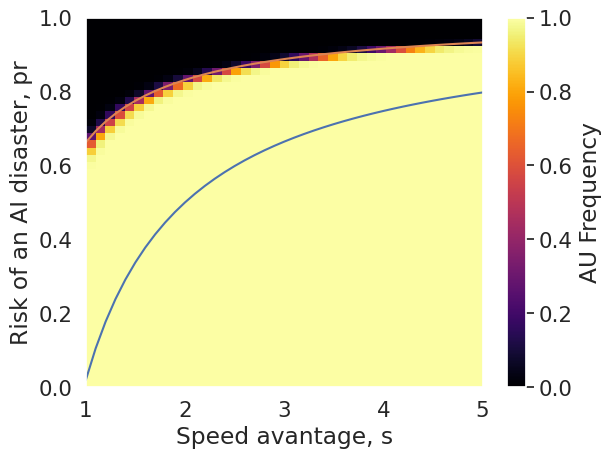

In [ ]:
#| echo:false
table = df.pivot_table(index='pr', columns='s', values='AU_frequency')

heatmap, ax = plt.subplots()
im = ax.imshow(table.values,
               cmap='inferno',
               extent=[table.columns.min(),
                       table.columns.max(),
                       table.index.min(),
                       table.index.max()],
               interpolation='nearest',
               origin='lower',
               aspect='auto')
ax.set(xlabel='Speed avantage, s',
       ylabel='Risk of an AI disaster, pr')

cbar = heatmap.colorbar(im)
cbar.ax.set_ylabel('AU Frequency')

# Add threshold boundaries to convey dilemma region
plt.plot(table.columns, df[df.pr==1]['threshold_society_prefers_safety'])
plt.plot(table.columns, df[df.pr==1]['threshold_risk_dominant_safety']);

:::{.callout-caution}
Note that this model is illustrative only: at best here, society refers to the collection of all firms.

We could instead explicitly model society's preferences over safety and innovation, distinct from the companies. Such a model will still have the 3 regions we are currently discussing, though the negative externalities of an AI disaster will likely lead to a greater *dillemma zone*. 

Another insight that such an extension would communicate is that companies may have incentive to work together to make sure their preferences are weighted more highly than the rest of society. It would be interesting to see whether we can observe this in pracitse, for examle in the European AI Act. The main challenge this task presents us is how to determine whether companies are working together to have their voices heard or whether they each already have strong enough incentives to uniltaterally influence policy.
:::

I have also plotted a cross-section of the above heatmap for speed advantage, $s=1.5$. This plot shows how players are distributed between the 2 available strategies, $AU$ and $AS$. Here, the blue area represents the proportion of players who follow $AU$ for each level of risk, whereas the red area tells us the proportion who play $AS$. I also mark the 3 regions discussed above.

We will often make use of this cross-section plot in more complex models when we want to show the relative frequencies of more than 2 strategies. 

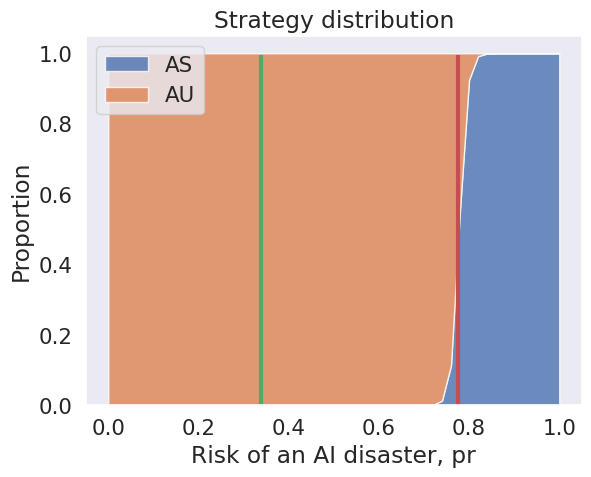

In [ ]:
#| echo:false
plot_strategy_distribution(df[df.s==1.5],
                           results['strategy_set'],
                           x="pr"
                          )

## DSAIR with punishment

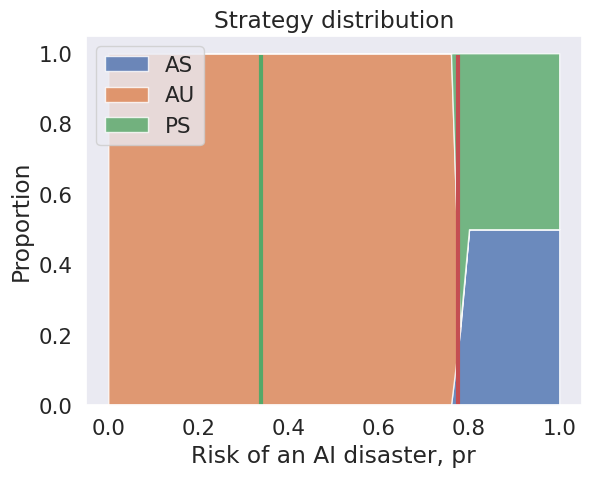

In [ ]:
#| exec_doc
#| echo:false
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    models = build_DSAIR(b=4,
                         c=1,
                         B=10**4,
                         W=100,
                         pfo=0,
                         α=0,
                         γ=0,
                         ϵ=0,
                         ω=0,
                         collective_risk=0,
                         β=0.1,
                         Z=100,
                         strategy_set=["AS", "AU", "PS"],
                        )

    results = thread_macro(models,
                           payoffs_sr,
                           payoffs_lr_peer_punishment,
                           threshold_society_prefers_safety_dsair,
                           threshold_risk_dominant_safety_dsair,
                           markov_chain,
                          )

    df = thread_macro(results,
                      results_to_dataframe_egt,
                      process_dsair_data)

    plot_strategy_distribution(df[df.s==1.5],
                               results['strategy_set'],
                               x="pr"
                              )

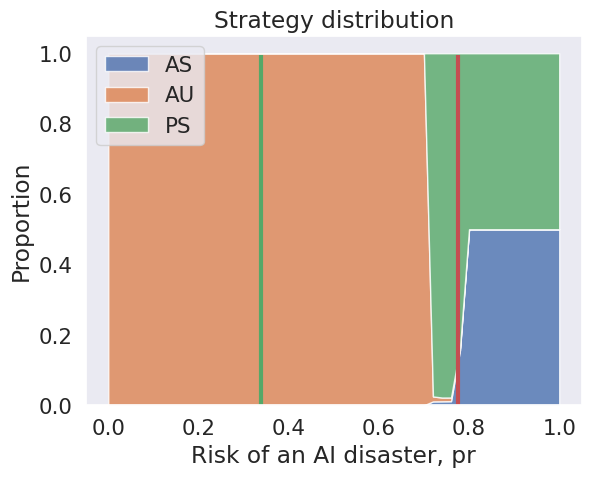

In [ ]:
#| exec_doc
#| echo:false
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    models = build_DSAIR(b=4,
                         c=1,
                         B=10**4,
                         W=100,
                         α=0.5,
                         γ=0.5,
                         β=0.1,
                         Z=100,
                         strategy_set=["AS", "AU", "PS"],
                         collective_risk=0)

    results = thread_macro(models,
                           payoffs_sr,
                           payoffs_lr_peer_punishment,
                           threshold_society_prefers_safety_dsair,
                           threshold_risk_dominant_safety_dsair,
                           markov_chain,
                          )

    df = thread_macro(results,
                      results_to_dataframe_egt,
                      process_dsair_data)

    plot_strategy_distribution(df[df.s==1.5],
                               results['strategy_set'],
                               x="pr"
                              )

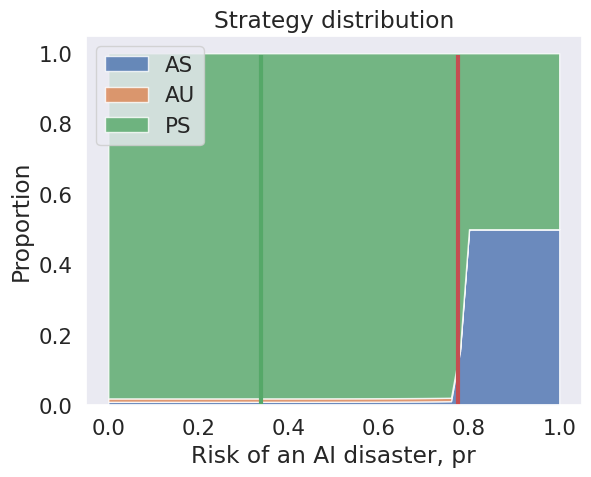

In [ ]:
#| exec_doc
#| echo:false
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    models = build_DSAIR(b=4,
                         c=1,
                         B=10**4,
                         W=100,
                         α=0.4,
                         γ=0.5,
                         β=0.1,
                         Z=100,
                         strategy_set=["AS", "AU", "PS"],
                         collective_risk=0)

    results = thread_macro(models,
                           payoffs_sr,
                           payoffs_lr_peer_punishment,
                           threshold_society_prefers_safety_dsair,
                           threshold_risk_dominant_safety_dsair,
                           markov_chain,
                          )

    df = thread_macro(results,
                      results_to_dataframe_egt,
                      process_dsair_data)

    plot_strategy_distribution(df[df.s==1.5],
                               results['strategy_set'],
                               x="pr"
                              )

The above plots show what the addition of peer punishment can do for the dynamics of an AI Development race. In the scenario presented above, a sufficiently large punishment can completely eliminate unsafe behaviour, even when the cost is somewhat large for the sanctioner (plot 3).

We compare this to a scenario where the sanctioner is all talk (i.e. punishment is costless to both parties). Here, we see no difference in the distribution of strategies compared to the baseline model (plot 1)

When the punishment hurts both parties equally, we see that it can curtail unsafe behavior, but to a far lesser extent. In such a scenario, it is more difficult for **PS** players to survive, so they provide less protection to **AS** players from **AS** players (plot 2).

One important takeaway which is apparent above is that punishments can be too punishing. Even when society collectively prefers that players are **AU**, punishment can prevent players from doing so. 

This isn't an obvious problem to overcome. Due to the Colignridge Dilemma, it will be very difficult for companies to determine what the risk of an AI disaster will be. 

We have so far only looked at short timelines. On longer timelines, we would expect punishments to be less effective, but we also expect the dilemma region to be smaller, so an interesting question is whether we should expect punishments to be as overzealous in restricting behaviour. Could it even be that punishments are insufficient to remove the dilemma zone on longer timelines?

The answer yes to both questions. See the plots below.

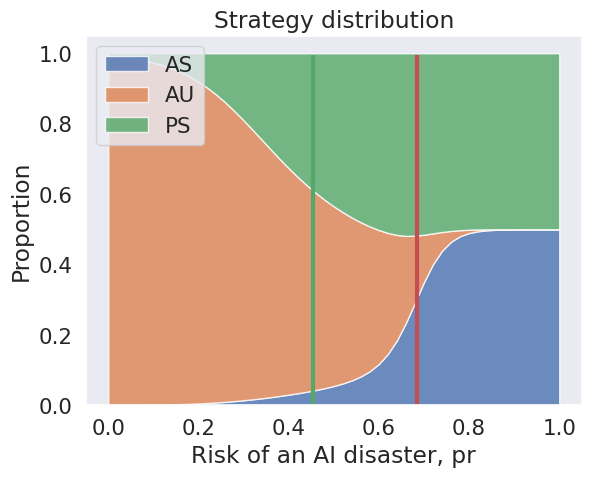

In [ ]:
#| exec_doc
#| echo:false
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    models = build_DSAIR(b=4,
                         c=1,
                         B=10**4,
                         W=10**4,
                         α=0.4,
                         γ=0.5,
                         β=0.1,
                         Z=100,
                         strategy_set=["AS", "AU", "PS"],
                         collective_risk=0)

    results = thread_macro(models,
                           payoffs_sr,
                           payoffs_lr_peer_punishment,
                           threshold_society_prefers_safety_dsair,
                           threshold_risk_dominant_safety_dsair,
                           markov_chain,
                          )

    df = thread_macro(results,
                      results_to_dataframe_egt,
                      process_dsair_data)

    plot_strategy_distribution(df[df.s==1.5],
                               results['strategy_set'],
                               x="pr"
                              )

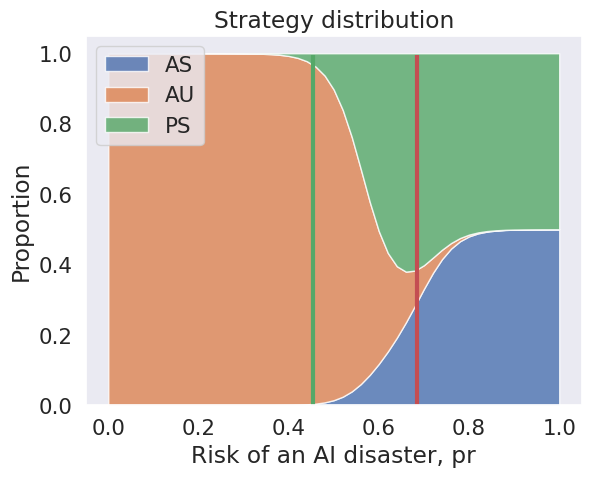

In [ ]:
#| exec_doc
#| echo:false
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    models = build_DSAIR(b=4,
                         c=1,
                         B=10**4,
                         W=10**4,
                         α=0.5,
                         γ=0.5,
                         β=0.1,
                         Z=100,
                         strategy_set=["AS", "AU", "PS"],
                         collective_risk=0)

    results = thread_macro(models,
                           payoffs_sr,
                           payoffs_lr_peer_punishment,
                           threshold_society_prefers_safety_dsair,
                           threshold_risk_dominant_safety_dsair,
                           markov_chain,
                          )

    df = thread_macro(results,
                      results_to_dataframe_egt,
                      process_dsair_data)

    plot_strategy_distribution(df[df.s==1.5],
                               results['strategy_set'],
                               x="pr"
                              )

#| hide

# References

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()